# Import libraries

In [0]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from pyspark.sql.functions import col, count, when,  regexp_replace
from pyspark.ml.feature import StringIndexer


# Importing Data

In [0]:
# Load the table from Hive
df_ind = spark.table("default.demographic_indicators")
# Show the first few rows of the DataFrame to verify it's loaded correctly
df_ind.show(5)

+-----+---------+-----------+----+---------------------------------------------+---------------------------------------+--------------------------------------+------------------------------------------+-------------------------------------------------------+---------------------------------------------------------+-------------------------------+----------------------------------------------+------------------------------------------+-----------------------------+-----------------------------------+---------------------------------------+------------------+-----------------------------------------+---------------------------------------------+--------------------------------------------+-----------------------------------------------------+-----------------------------+------------------------------------------------+------------------------+-----------------------+-------------------------+---------------------------------------------+-------------------------------------------+------

In [0]:
# Load the table from Hive
df_gdp = spark.table("default.maddison_data_gdp_per_capita_in_2011_us_slopechart")
# Show the first few rows of the DataFrame to verify it's loaded correctly
df_gdp.show(5)

+-----------+--------+----+--------------+------------------+---------+
|     Entity|    Code|Year|GDP per capita|417485-annotations|Continent|
+-----------+--------+----+--------------+------------------+---------+
|   Abkhazia|OWID_ABK|2015|          NULL|              NULL|     Asia|
|Afghanistan|     AFG|1950|        1156.0|              NULL|     NULL|
|Afghanistan|     AFG|1951|        1170.0|              NULL|     NULL|
|Afghanistan|     AFG|1952|        1189.0|              NULL|     NULL|
|Afghanistan|     AFG|1953|        1240.0|              NULL|     NULL|
+-----------+--------+----+--------------+------------------+---------+
only showing top 5 rows



# Data Analysis and Pre-processing


## Combine data and Remove Duplicates 

### Mapping Country and Year wise

In [0]:
# Number of rows in the DataFrame
num_rows = df_ind.count()
print(f"Number of rows: {num_rows}")

# Number of columns in the DataFrame
num_columns = len(df_ind.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 20596
Number of columns: 58


In [0]:
# Number of rows in the DataFrame
num_rows = df_gdp.count()
print(f"Number of rows: {num_rows}")

# Number of columns in the DataFrame
num_columns = len(df_gdp.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 19993
Number of columns: 6


In [0]:
df_gdp = df_gdp.withColumnRenamed("Year", "Year_gdp")

# Show renamed DataFrame
print("DataFrame After Renaming Multiple Columns:")
df_gdp.show()

DataFrame After Renaming Multiple Columns:
+-----------+--------+--------+--------------+------------------+---------+
|     Entity|    Code|Year_gdp|GDP per capita|417485-annotations|Continent|
+-----------+--------+--------+--------------+------------------+---------+
|   Abkhazia|OWID_ABK|    2015|          NULL|              NULL|     Asia|
|Afghanistan|     AFG|    1950|        1156.0|              NULL|     NULL|
|Afghanistan|     AFG|    1951|        1170.0|              NULL|     NULL|
|Afghanistan|     AFG|    1952|        1189.0|              NULL|     NULL|
|Afghanistan|     AFG|    1953|        1240.0|              NULL|     NULL|
|Afghanistan|     AFG|    1954|        1245.0|              NULL|     NULL|
|Afghanistan|     AFG|    1955|        1246.0|              NULL|     NULL|
|Afghanistan|     AFG|    1956|        1278.0|              NULL|     NULL|
|Afghanistan|     AFG|    1957|        1253.0|              NULL|     NULL|
|Afghanistan|     AFG|    1958|        1298.0

In [0]:
df = df_ind.join(df_gdp, (df_gdp.Entity == df_ind.area) & (df_gdp.Year_gdp == df_ind.Year), "inner")

In [0]:
# Number of rows in the DataFrame
num_rows = df.count()
print(f"Number of rows: {num_rows}")

# Number of columns in the DataFrame
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 10471
Number of columns: 64


In [0]:
df=df.drop("Year")

### Check for null Values

In [0]:
# First, collect the DataFrame as a dictionary
null_counts_dict = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()

# Convert the dictionary to a pandas DataFrame and transpose it
null_counts_pd = pd.DataFrame([null_counts_dict]).T
null_counts_pd.columns = ['Null Count']
null_counts_pd.index.name = 'Column'

# Show the pandas DataFrame
print(null_counts_pd)


                                               Null Count
Column                                                   
Index                                                   0
Variant                                                 0
area                                                    0
Total Population as of 1 January in thousands           0
Total Population as of 1 July thousands                 0
...                                                   ...
Code                                                    0
Year_gdp                                                0
GDP per capita                                         65
417485-annotations                                  10471
Continent                                           10247

[63 rows x 1 columns]


In [0]:
df= df.drop("417485-annotations","Continent","Index")

In [0]:
# Drop rows with any null values across all columns
df = df.dropna(how='any')

# Show the updated DataFrame to verify changes
df.show()

+---------+-------+---------------------------------------------+---------------------------------------+--------------------------------------+------------------------------------------+-------------------------------------------------------+---------------------------------------------------------+-------------------------------+----------------------------------------------+------------------------------------------+-----------------------------+-----------------------------------+---------------------------------------+------------------+-----------------------------------------+---------------------------------------------+--------------------------------------------+-----------------------------------------------------+-----------------------------+------------------------------------------------+------------------------+-----------------------+-------------------------+---------------------------------------------+-------------------------------------------+---------------------

In [0]:
# First, collect the DataFrame as a dictionary
null_counts_dict = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()

# Convert the dictionary to a pandas DataFrame and transpose it
null_counts_pd = pd.DataFrame([null_counts_dict]).T
null_counts_pd.columns = ['Null Count']
null_counts_pd.index.name = 'Column'

# Show the pandas DataFrame
print(null_counts_pd)

                                                    Null Count
Column                                                        
Variant                                                      0
area                                                         0
Total Population as of 1 January in thousands                0
Total Population as of 1 July thousands                      0
Male Population as of 1 July thousands                       0
Female Population as of 1 July (thousands)                   0
Population Density as of 1 July (persons per sq...           0
Population Sex Ratio as of 1 July (males per 10...           0
Median Age as of 1 July (years)                              0
Natural Change Births minus Deaths (thousands)               0
Rate of Natural Change per 1000 population                   0
Population Change (thousands)                                0
Population Growth Rate (percentage)                          0
Population Annual Doubling Time (years)                

In [0]:
# Number of rows in the DataFrame
num_rows = df.count()
print(f"Number of rows: {num_rows}")

# Number of columns in the DataFrame
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 10406
Number of columns: 60


## Encoding

In [0]:
# Get the DataFrame schema
schema = df.schema

# Create a dictionary to store the column names and their respective data types
column_types = {}

# Iterate through each column in the schema
for column in schema.fields:
    # Add the column name and data type to the dictionary
    column_types[column.name] = column.dataType.simpleString()

# Print the column names and their data types
for column_name, column_type in column_types.items():
    print(f"{column_name}: {column_type}")

Variant: string
area: string
Total Population as of 1 January in thousands: string
Total Population as of 1 July thousands: string
Male Population as of 1 July thousands: string
Female Population as of 1 July (thousands): string
Population Density as of 1 July (persons per square km): string
Population Sex Ratio as of 1 July (males per 100 females): string
Median Age as of 1 July (years): string
Natural Change Births minus Deaths (thousands): string
Rate of Natural Change per 1000 population: string
Population Change (thousands): string
Population Growth Rate (percentage): string
Population Annual Doubling Time (years): string
Births (thousands): string
Births by women aged 15 to 19 (thousands): string
Crude Birth Rate (births per 1000 population): string
Total Fertility Rate (live births per woman): string
Net Reproduction Rate (surviving daughters per woman): string
Mean Age Childbearing (years): string
Sex Ratio at Birth (males per 100 female births): string
Total Deaths (thousands)

In [0]:
# Create an indexer
indexer = StringIndexer(inputCol="Variant", outputCol="Variant_Index")

# Fit the indexer to the data
model = indexer.fit(df)

# Transform the data to encode the 'Variant' column
df = model.transform(df)

# Show the first few rows to verify the transformed data
df.select("Variant", "Variant_Index").show()


+---------+-------------+
|  Variant|Variant_Index|
+---------+-------------+
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
|Estimates|          0.0|
+---------+-------------+
only showing top 20 rows



In [0]:
indexer = StringIndexer(inputCol="area", outputCol="area_Index")

# Fit the indexer to the data
model = indexer.fit(df)

# Transform the data to encode the 'Variant' column
df = model.transform(df)

# Show the first few rows to verify the transformed data
df.select("area", "area_Index").show()

+-------+----------+
|   area|area_Index|
+-------+----------+
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
|Burundi|      17.0|
+-------+----------+
only showing top 20 rows



In [0]:
model

StringIndexerModel: uid=StringIndexer_dec28fc1b7fa, handleInvalid=error

In [0]:
df.show()

+---------+-------+---------------------------------------------+---------------------------------------+--------------------------------------+------------------------------------------+-------------------------------------------------------+---------------------------------------------------------+-------------------------------+----------------------------------------------+------------------------------------------+-----------------------------+-----------------------------------+---------------------------------------+------------------+-----------------------------------------+---------------------------------------------+--------------------------------------------+-----------------------------------------------------+-----------------------------+------------------------------------------------+------------------------+-----------------------+-------------------------+---------------------------------------------+-------------------------------------------+---------------------

In [0]:
df= df.drop('Variant', 'area','Entity','Code')

# Show the updated DataFrame structure to verify the columns are dropped
df.show()

+---------------------------------------------+---------------------------------------+--------------------------------------+------------------------------------------+-------------------------------------------------------+---------------------------------------------------------+-------------------------------+----------------------------------------------+------------------------------------------+-----------------------------+-----------------------------------+---------------------------------------+------------------+-----------------------------------------+---------------------------------------------+--------------------------------------------+-----------------------------------------------------+-----------------------------+------------------------------------------------+------------------------+-----------------------+-------------------------+---------------------------------------------+-------------------------------------------+-------------------------------------+-

In [0]:
# Get the DataFrame schema
schema = df.schema

# Create a dictionary to store the column names and their respective data types
column_types = {}

# Iterate through each column in the schema
for column in schema.fields:
    # Add the column name and data type to the dictionary
    column_types[column.name] = column.dataType.simpleString()

# Print the column names and their data types
for column_name, column_type in column_types.items():
    print(f"{column_name}: {column_type}")

Total Population as of 1 January in thousands: string
Total Population as of 1 July thousands: string
Male Population as of 1 July thousands: string
Female Population as of 1 July (thousands): string
Population Density as of 1 July (persons per square km): string
Population Sex Ratio as of 1 July (males per 100 females): string
Median Age as of 1 July (years): string
Natural Change Births minus Deaths (thousands): string
Rate of Natural Change per 1000 population: string
Population Change (thousands): string
Population Growth Rate (percentage): string
Population Annual Doubling Time (years): string
Births (thousands): string
Births by women aged 15 to 19 (thousands): string
Crude Birth Rate (births per 1000 population): string
Total Fertility Rate (live births per woman): string
Net Reproduction Rate (surviving daughters per woman): string
Mean Age Childbearing (years): string
Sex Ratio at Birth (males per 100 female births): string
Total Deaths (thousands): string
Male Deaths (thousan

### Convert String coloums to float

In [0]:
# List of columns to convert to integer, assuming they're formatted as strings with possible commas
columns_to_convert = [
    "Total Population as of 1 January in thousands",
    "Total Population as of 1 July thousands",
    "Male Population as of 1 July thousands",
    "Female Population as of 1 July (thousands)",
    "Population Density as of 1 July (persons per square km)",
    "Population Sex Ratio as of 1 July (males per 100 females)",
    "Median Age as of 1 July (years)",
    "Natural Change Births minus Deaths (thousands)",
    "Rate of Natural Change per 1000 population",
    "Population Change (thousands)",
    "Population Growth Rate (percentage)",
    "Population Annual Doubling Time (years)",
    "Births (thousands)",
    "Births by women aged 15 to 19 (thousands)",
    "Crude Birth Rate (births per 1000 population)",
    "Total Fertility Rate (live births per woman)",
    "Net Reproduction Rate (surviving daughters per woman)",
    "Mean Age Childbearing (years)",
    "Sex Ratio at Birth (males per 100 female births)",
    "Total Deaths (thousands)",
    "Male Deaths (thousands)",
    "Female Deaths (thousands)",
    "Crude Death Rate (deaths per 1000 population)",
    "Life Expectancy at Birth both sexes (years)",
    "Male Life Expectancy at Birth (years)",
    "Female Life Expectancy at Birth (years)",
    "Life Expectancy at Age 15 both sexes (years)",
    "Male Life Expectancy at Age 15 (years)",
    "Female Life Expectancy at Age 15 (years)",
    "Life Expectancy at Age 65 both sexes (years)",
    "Male Life Expectancy at Age 65 (years)",
    "Female Life Expectancy at Age 65 (years)",
    "Life Expectancy at Age 80 both sexes (years)",
    "Male Life Expectancy at Age 80 (years)",
    "Female Life Expectancy at Age 80 (years)",
    "Infant Deaths under age 1 (thousands)",
    "Infant Mortality Rate (infant deaths per 1000 live births)",
    "Live Births Surviving to Age 1 (thousands)",
    "Under-Five Deaths under age 5 (thousands)",
    "Under-Five Mortality (deaths under age 5 per 1000 live births)",
    "Mortality before Age 40 both sexes (deaths under age 40 per 1000 live births)",
    "Male Mortality before Age 40 (deaths under age 40 per 1000 male live births)",
    "Female Mortality before Age 40 (deaths under age 40 per 1000 female live births)",
    "Mortality before Age 60 both sexes (deaths under age 60 per 1000 live births)",
    "Male Mortality before Age 60 (deaths under age 60 per 1000 male live births)",
    "Female Mortality before Age 60 (deaths under age 60 per 1000 female live births)",
    "Mortality between Age 15 and 50 both sexes (deaths under age 50 per 1000 alive at age 15)",
    "Male Mortality between Age 15 and 50 (deaths under age 50 per 1000 males alive at age 15)",
    "Female Mortality between Age 15 and 50 (deaths under age 50 per 1000 females alive at age 15)",
    "Mortality between Age 15 and 60 both sexes (deaths under age 60 per 1000 alive at age 15)",
    "Male Mortality between Age 15 and 60 (deaths under age 60 per 1000 males alive at age 15)",
    "Female Mortality between Age 15 and 60 (deaths under age 60 per 1000 females alive at age 15)",
    "Net Number of Migrants (thousands)",
    "Net Migration Rate (per 1000 population)"
]

# Convert each column from string to integer
for column_name in columns_to_convert:
    df = df.withColumn(column_name, regexp_replace(regexp_replace(col(column_name), " ", ""), ",", "").cast("float"))

# Show the updated DataFrame structure to verify the type changes
df.printSchema()

root
 |-- Total Population as of 1 January in thousands: float (nullable = true)
 |-- Total Population as of 1 July thousands: float (nullable = true)
 |-- Male Population as of 1 July thousands: float (nullable = true)
 |-- Female Population as of 1 July (thousands): float (nullable = true)
 |-- Population Density as of 1 July (persons per square km): float (nullable = true)
 |-- Population Sex Ratio as of 1 July (males per 100 females): float (nullable = true)
 |-- Median Age as of 1 July (years): float (nullable = true)
 |-- Natural Change Births minus Deaths (thousands): float (nullable = true)
 |-- Rate of Natural Change per 1000 population: float (nullable = true)
 |-- Population Change (thousands): float (nullable = true)
 |-- Population Growth Rate (percentage): float (nullable = true)
 |-- Population Annual Doubling Time (years): float (nullable = true)
 |-- Births (thousands): float (nullable = true)
 |-- Births by women aged 15 to 19 (thousands): float (nullable = true)
 |--

# Outliners


In [0]:
for column in df.columns:
    df.describe([column]).show(truncate=False)

+-------+---------------------------------------------+
|summary|Total Population as of 1 January in thousands|
+-------+---------------------------------------------+
|count  |10406                                        |
|mean   |28995.210167211226                           |
|stddev |111888.88515790411                           |
|min    |24.0                                         |
|max    |1414409.0                                    |
+-------+---------------------------------------------+

+-------+---------------------------------------+
|summary|Total Population as of 1 July thousands|
+-------+---------------------------------------+
|count  |10406                                  |
|mean   |29224.150970593888                     |
|stddev |112652.4015491944                      |
|min    |24.0                                   |
|max    |1417069.0                              |
+-------+---------------------------------------+

+-------+-----------------------------------

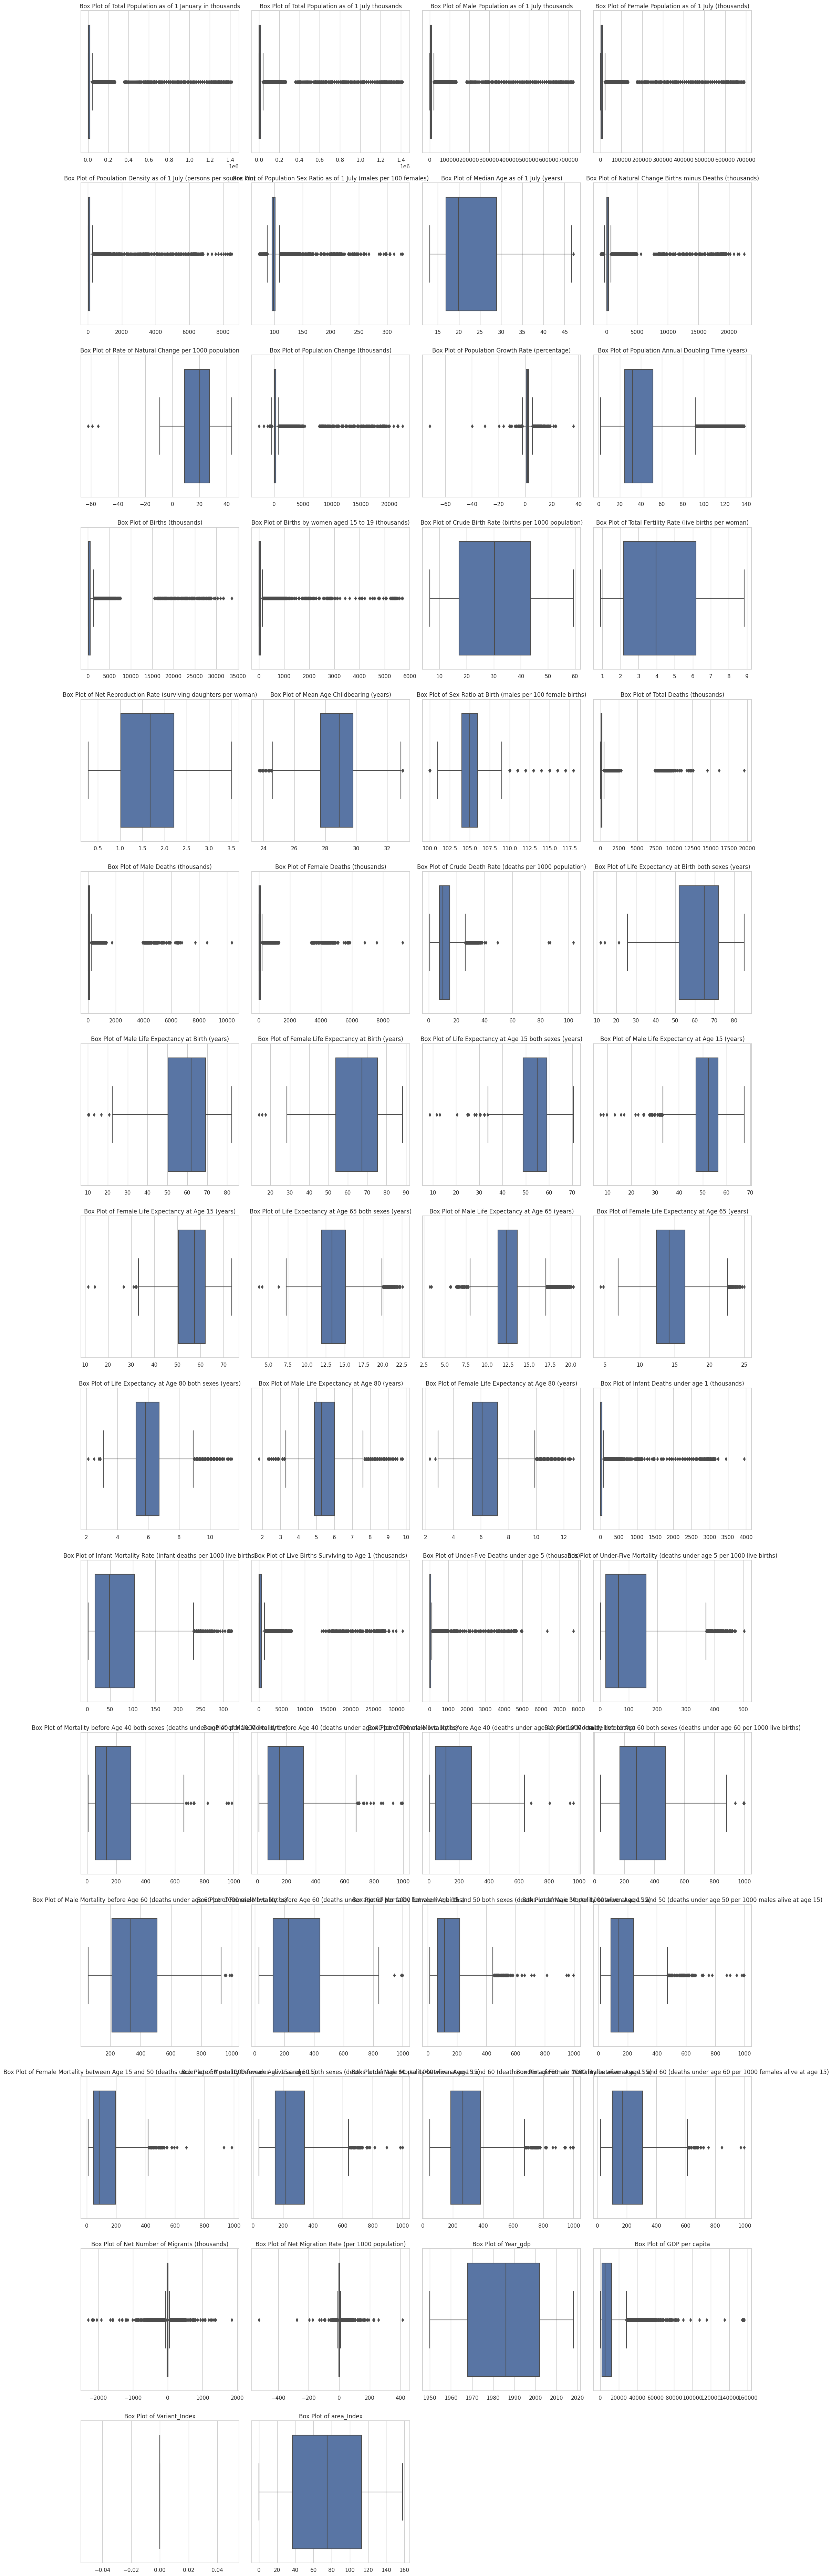

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting aesthetics for plots
sns.set(style="whitegrid")
pandas_df = df.toPandas()
# Determine number of columns and appropriate figure size
num_cols = len(pandas_df.columns)
num_rows = (num_cols + 3) // 4  # Arranging plots in a grid of 4 columns

# Create a large figure to accommodate all subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten the axis array

# Loop through all columns and create a box plot for each
for i, column in enumerate(pandas_df.columns):
    sns.boxplot(x=pandas_df[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any unused axes if the number of plots is not a perfect multiple of 4
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


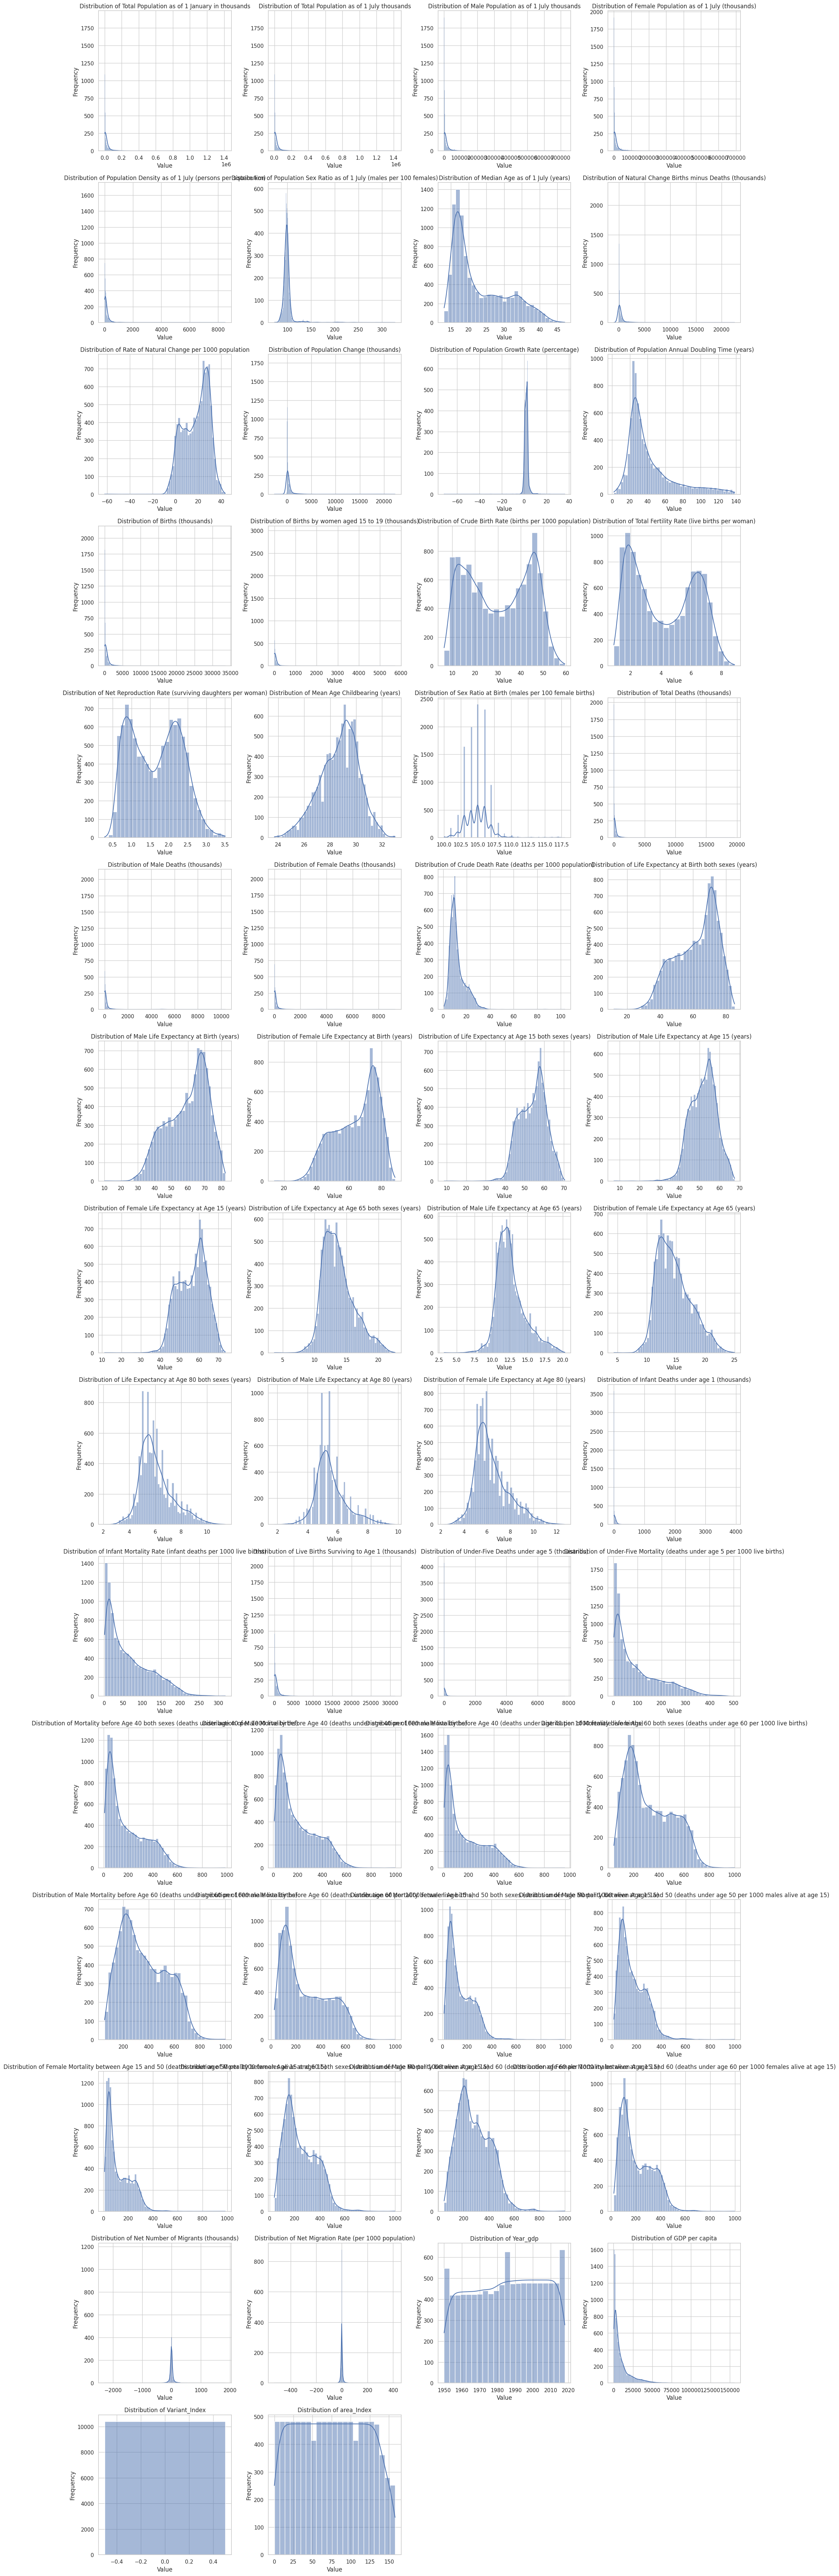

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Filter for numeric columns from the pandas DataFrame
pandas_df = df.toPandas()
# Determine number of columns and appropriate figure size
num_cols = len(pandas_df.columns)
numeric_columns = pandas_df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
num_cols = len(numeric_columns)
num_rows = (num_cols + 3) // 4  # Calculate the number of rows needed in the grid

# Create a large figure to accommodate all subplot
fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))  # Adjust subplot grid and size
axes = axes.flatten()  # Flatten the axes array

# Loop through numeric columns and create a histogram for each
for i, column in enumerate(numeric_columns):
    sns.histplot(pandas_df[column], kde=True, ax=axes[i])  # Using kernel density estimation for smooth distribution
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused axes if the number of plots is not a perfect multiple of 4
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# Corelation

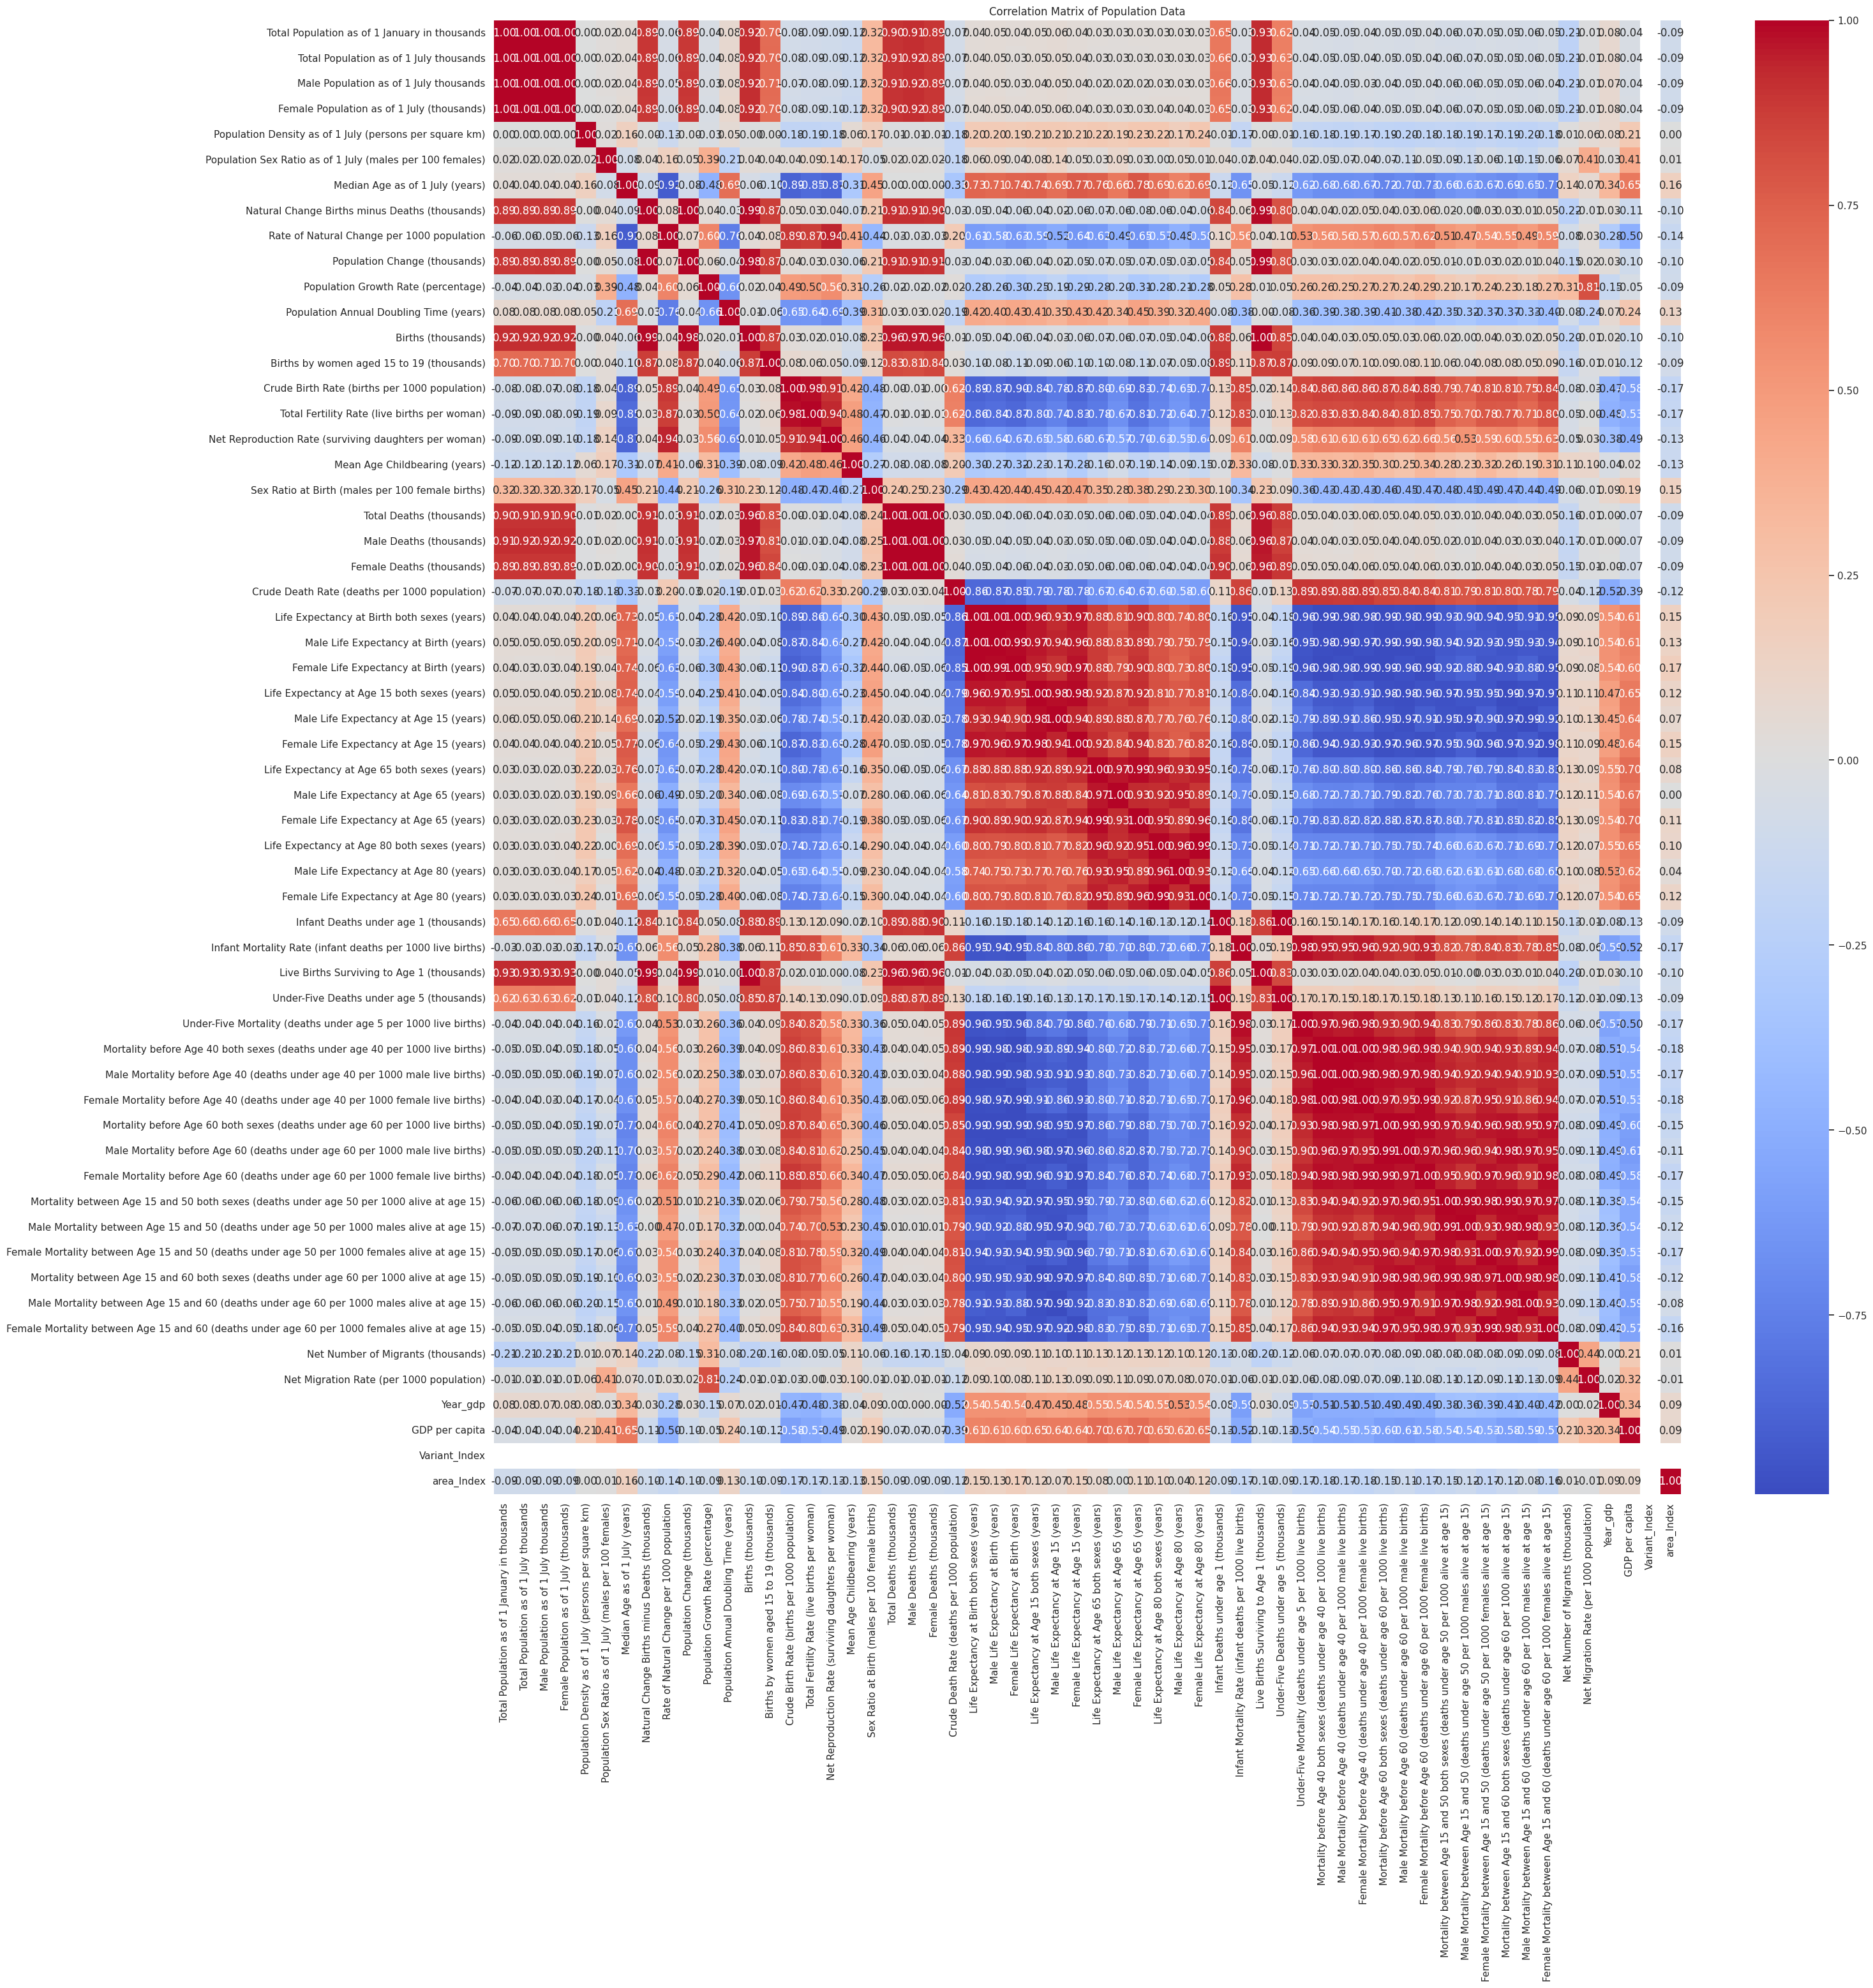

In [0]:
import numpy as np

# Create a correlation matrix
corr_matrix = pandas_df.corr()

# Heatmap for the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Population Data")
plt.show()

In [0]:
pd.set_option('display.max_rows', None)    # Ensures all rows are displayed
pd.set_option('display.max_columns', None) # Ensures all columns are displayed
pd.set_option('display.width', None)       # Ensures the display width is expanded as needed
pd.set_option('display.max_colwidth', None) # Ensures full width of each column is displayed

# Print the correlation matrix
print(corr_matrix)

                                                                                               Total Population as of 1 January in thousands  \
Total Population as of 1 January in thousands                                                                                       1.000000   
Total Population as of 1 July thousands                                                                                             0.999994   
Male Population as of 1 July thousands                                                                                              0.999876   
Female Population as of 1 July (thousands)                                                                                          0.999896   
Population Density as of 1 July (persons per square km)                                                                             0.003105   
Population Sex Ratio as of 1 July (males per 100 females)                                                                           0.02

# Analysis

In [0]:
pandas_df = df.toPandas()

### 1. Histogram - Distribution of GDP per Capita

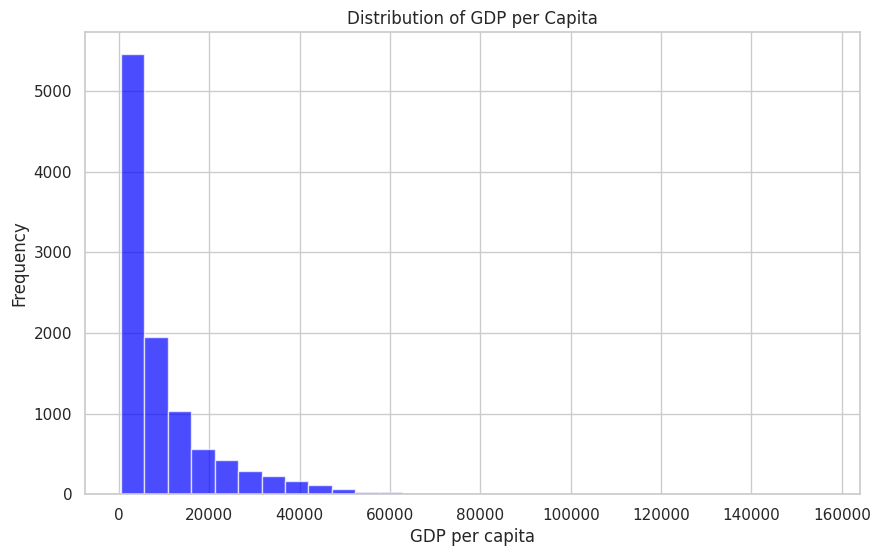

In [0]:
# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['GDP per capita'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of GDP per Capita')
plt.xlabel('GDP per capita')
plt.ylabel('Frequency')
plt.show()


#### Data Distribution
The histogram shows a right-skewed distribution

#### Skewness 
Since the tail of the distribution extends to the right and there are some bars to the far right, we can conclude that there are outliers or a small number of entities with an exceptionally high GDP per capita.

#### Economic Disparity
The spread of the histogram, with a concentration of data points towards the lower end, indicates economic disparity. A few entities have a very high GDP per capita, while the vast majority have a much lower GDP per capita. This suggests a disparity in economic wealth among the entities analyzed.

#### Potential Outliers
The entities that fall into the far-right bins, beyond the general clustering of data, could be considered outliers. These would be entities with an unusually high GDP per capita, possibly due to being small, wealthy countries or regions with significant natural resource wealth or highly developed financial sectors.

### 2. Boxplot - Comparing Life Expectancies

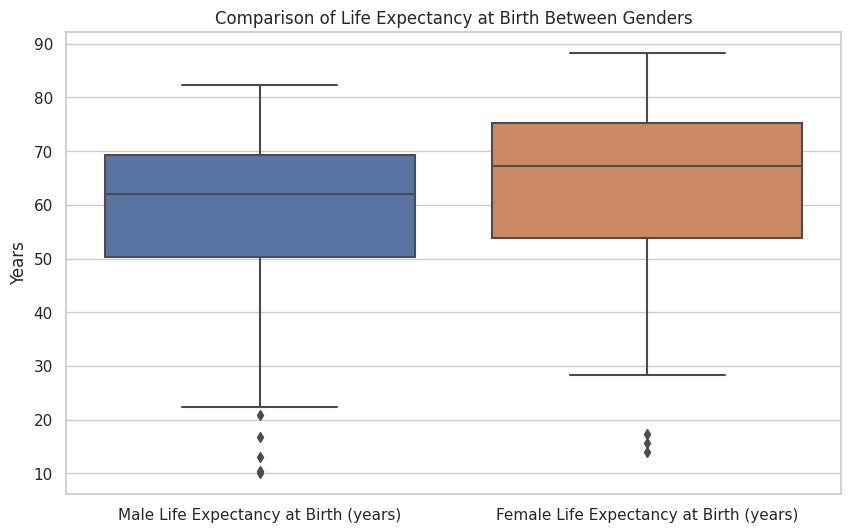

In [0]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pandas_df[['Male Life Expectancy at Birth (years)', 'Female Life Expectancy at Birth (years)']])
plt.title('Comparison of Life Expectancy at Birth Between Genders')
plt.ylabel('Years')
plt.show()

#### Comparison Between Genders: ( females generally living longer than males )
There's a noticeable difference in the median life expectancy between genders, with females generally living longer than males. This is a common trend observed worldwide and could be attributed to a variety of biological, social, and environmental factors.

#### Whiskers: (greater variation in male life expectancy)
The 'whiskers' extend from the box to the highest and lowest values within 1.5 times the IQR from the upper and lower quartiles, respectively. It seems that the range for males is slightly wider than for females, indicating greater variation in male life expectancy.

### 3. Scatter Plot - GDP vs. Life Expectancy

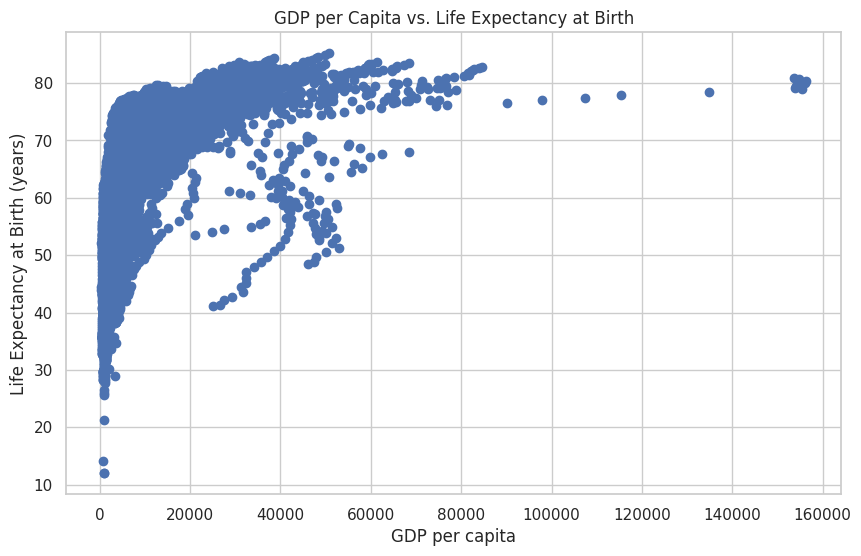

In [0]:
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['GDP per capita'], pandas_df['Life Expectancy at Birth both sexes (years)'])
plt.title('GDP per Capita vs. Life Expectancy at Birth')
plt.xlabel('GDP per capita')
plt.ylabel('Life Expectancy at Birth (years)')
plt.show()

#### Positive Correlation: (GDP per capita increases, life expectancy at birth tends to increase as well)
There appears to be a positive correlation between GDP per capita and life expectancy at birth, meaning that as GDP per capita increases, life expectancy at birth tends to increase as well. This is evident from the general upward trend of the data points from the bottom left towards the top right of the graph.

#### Diminishing Returns: ( life expectancy slows down as GDP per capita grows )
The rate of increase in life expectancy slows down as GDP per capita grows. Initially, for lower GDP values, life expectancy rises sharply with economic gains. However, as GDP per capita continues to increase, the life expectancy improvements become more gradual. This could be indicative of diminishing returns, where the impact of economic gains on life expectancy reduces as income levels become very high.

### 4. Bar Chart - Average Births by Decade

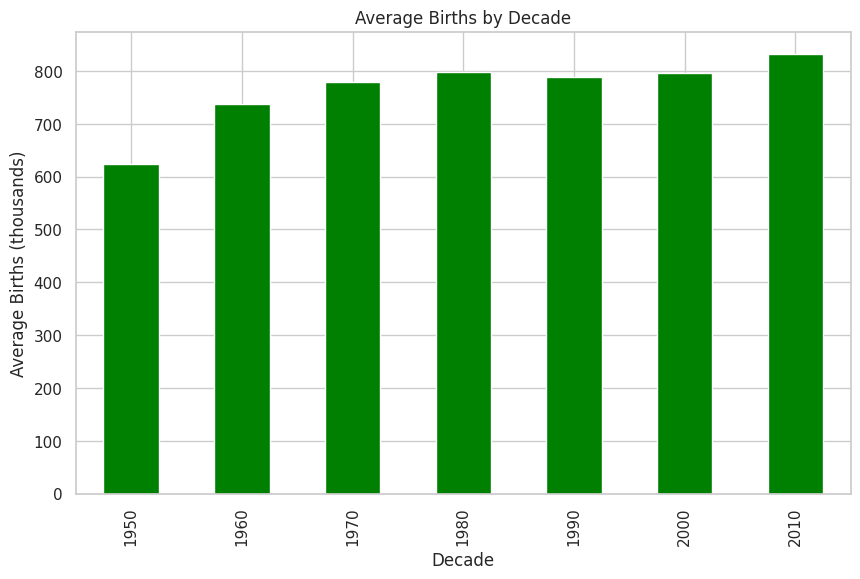

In [0]:
pandas_df['decade'] = (pandas_df['Year_gdp'] // 10) * 10  # Create a decade column
decade_means = pandas_df.groupby('decade')['Births (thousands)'].mean()

plt.figure(figsize=(10, 6))
decade_means.plot(kind='bar', color='green')
plt.title('Average Births by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Births (thousands)')
plt.show()

#### Trend Over Time: 
There is an initial increase in average births from the 1950s to the 1960s, suggesting a baby boom period. After the 1960s, the average births begin to decline slightly or stabilize across subsequent decades.

#### Why this data
##### 1 Policy Implications: 
Understanding these trends is crucial for policymakers in planning for future resource needs, such as schools, healthcare, and social security systems.
##### 2 Cultural and Economic Factors: 
Cultural shifts and economic conditions often influence family planning decisions and can be reflected in birth rate trends. Economic prosperity or downturns, cultural norms around family size, and the availability of family planning services all play a role

### 5. Line Plot - Trends in Infant Mortality Rate Over Years

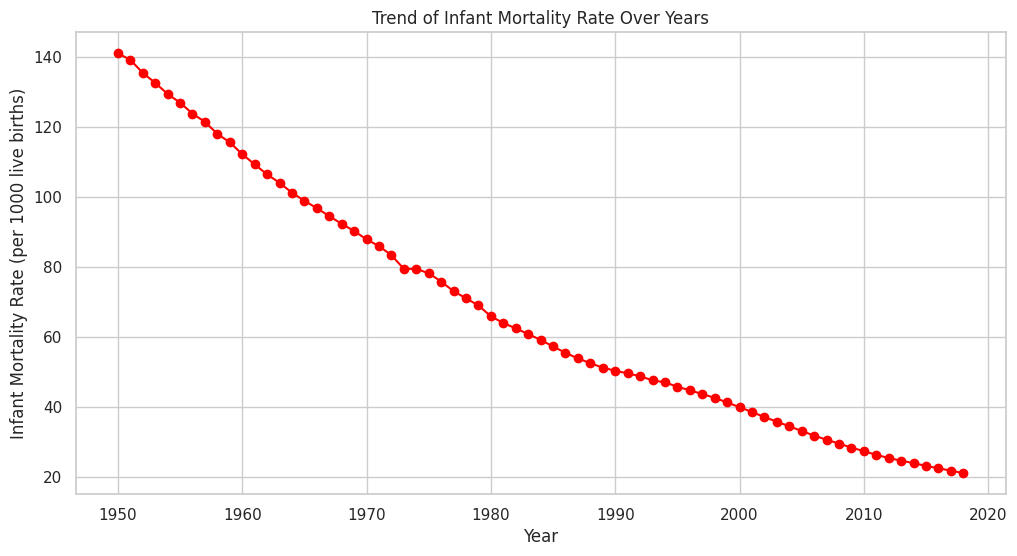

In [0]:
yearly_data = pandas_df.groupby('Year_gdp')['Infant Mortality Rate (infant deaths per 1000 live births)'].mean()

plt.figure(figsize=(12, 6))
yearly_data.plot(kind='line', marker='o', linestyle='-', color='red')
plt.title('Trend of Infant Mortality Rate Over Years')
plt.xlabel('Year')
plt.ylabel('Infant Mortality Rate (per 1000 live births)')
plt.show()

#### Infant Mortality Rate: 
The vertical axis measures the infant mortality rate, which is a key indicator of a country's health and development status. The rate is presented per 1,000 live births.
##### Health Improvements: 
The downward trend is a positive sign, typically reflecting improvements in healthcare, better access to medical facilities, enhanced nutrition, advancements in medical technology, and improved health education and practices among the population.

#### Potential for Further Analysis

### 6. Density Plot - Population Density

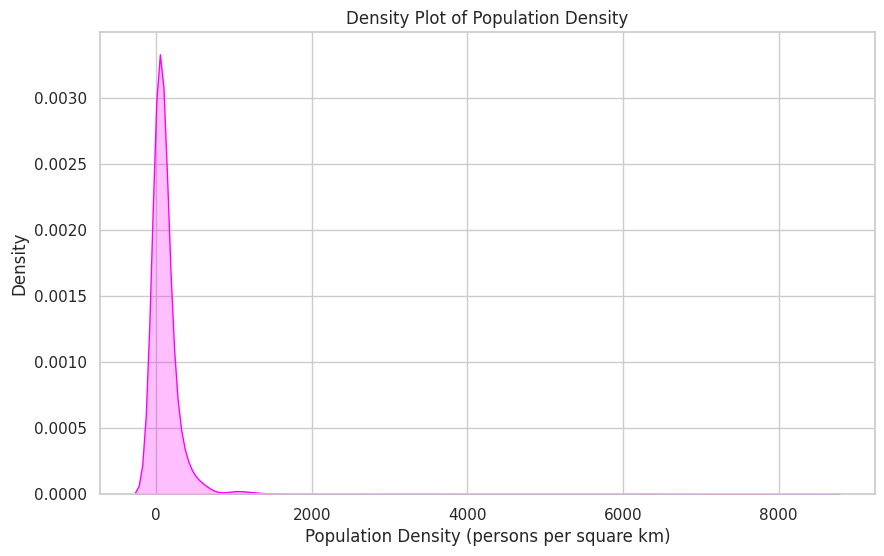

In [0]:
plt.figure(figsize=(10, 6))
sns.kdeplot(pandas_df['Population Density as of 1 July (persons per square km)'], color='magenta', fill=True)
plt.title('Density Plot of Population Density')
plt.xlabel('Population Density (persons per square km)')
plt.show()

#### Distribution Shape
The plot shows a very steep peak close to zero, indicating that most of the data points (regions/countries/cities) have a low population density. This is typical for population density data, where vast areas have low human habitation.

#### Skewness 
The distribution is right-skewed, with a tail that extends far to the right. This long tail suggests that while most places have low population density, there are a few areas with extremely high population density.

#### Central Tendency
Since the KDE plot is peaked and skewed, the mean population density would be higher than the median, and most of the population density values lie below the mean.

### 7. Violin Plot - Comparison of Population Changes

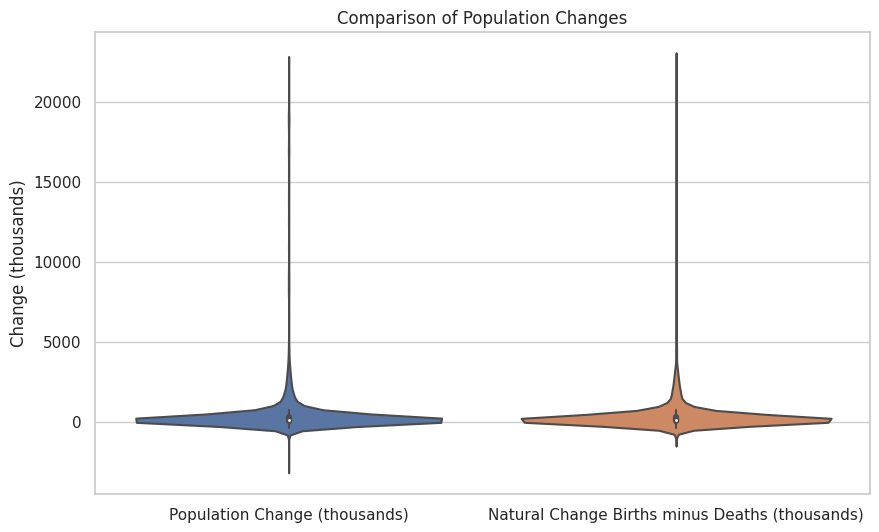

In [0]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=pandas_df[['Population Change (thousands)', 'Natural Change Births minus Deaths (thousands)']])
plt.title('Comparison of Population Changes')
plt.ylabel('Change (thousands)')
plt.show()

#### Population Change: 
This likely refers to the total change in the population, which can include natural growth (births minus deaths) and net migration (immigrants minus emigrants).
#### Natural Change: 
This is the natural increase or decrease in the population, calculated as the number of births minus the number of deaths.

### 8. Pair Plot - Relationships Among Various Population Metrics

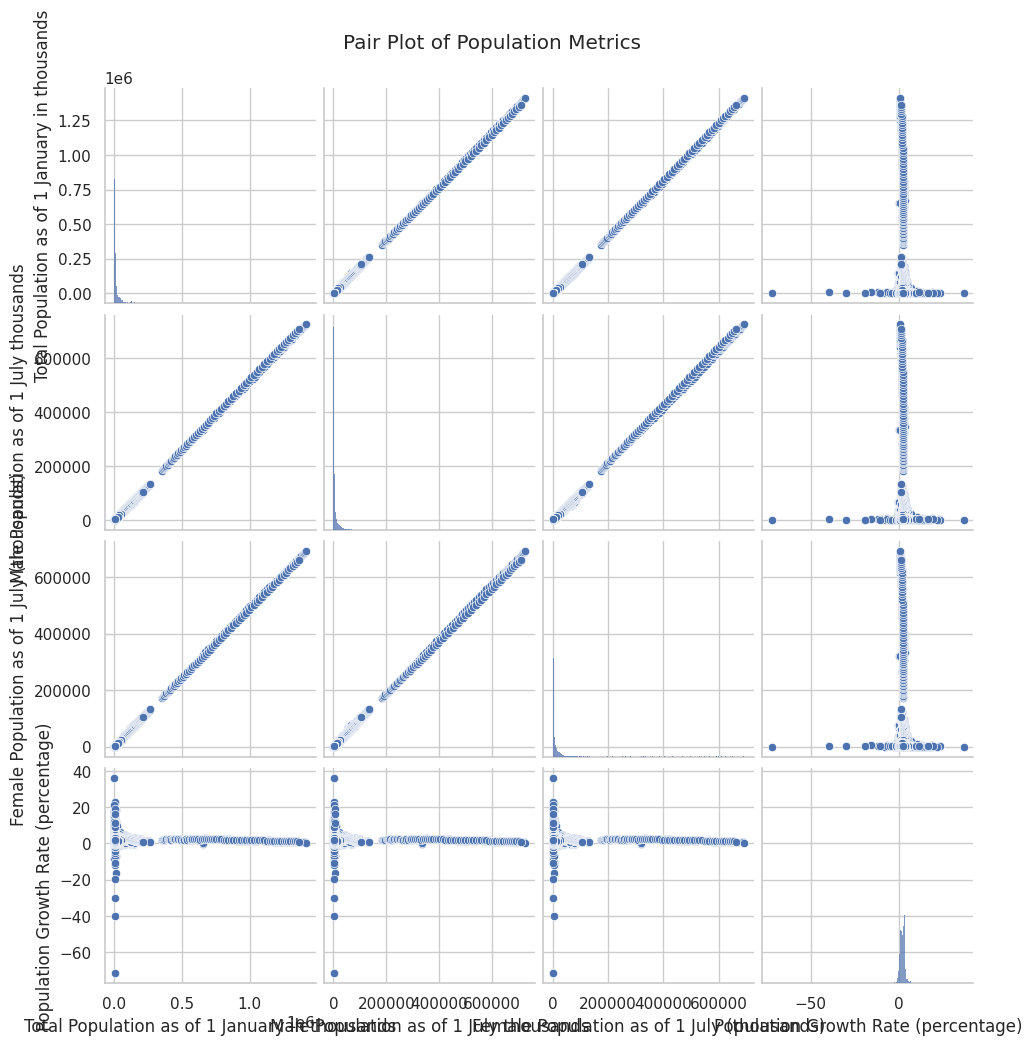

In [0]:
subset = pandas_df[['Total Population as of 1 January in thousands', 'Male Population as of 1 July thousands', 'Female Population as of 1 July (thousands)', 'Population Growth Rate (percentage)']]
sns.pairplot(subset)
plt.suptitle('Pair Plot of Population Metrics', y=1.02)
plt.show()

### 9. Heatmap - Correlation of Selected Demographic Variables

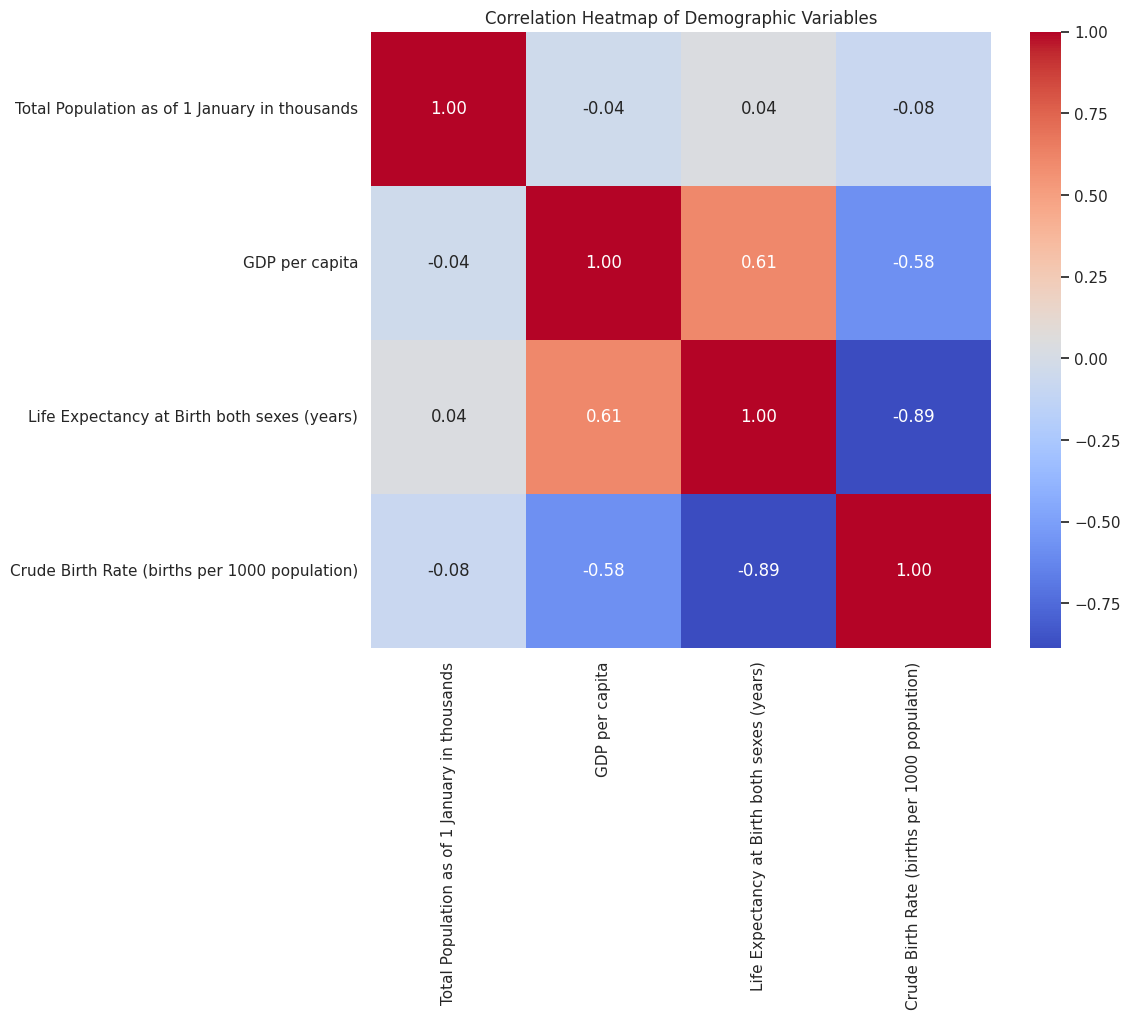

In [0]:
demo_vars = pandas_df[['Total Population as of 1 January in thousands', 'GDP per capita', 'Life Expectancy at Birth both sexes (years)', 'Crude Birth Rate (births per 1000 population)']]
correlation_matrix = demo_vars.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Demographic Variables')
plt.show()

#### Color Coding: 
The heatmap uses a 'coolwarm' color scheme where red tones represent positive correlation, blue tones represent negative correlation, and colors closer to white represent little to no correlation.



### 10. Stacked Bar Chart - Male vs. Female Deaths by Decade

<module 'matplotlib.pyplot' from '/databricks/python/lib/python3.10/site-packages/matplotlib/pyplot.py'>

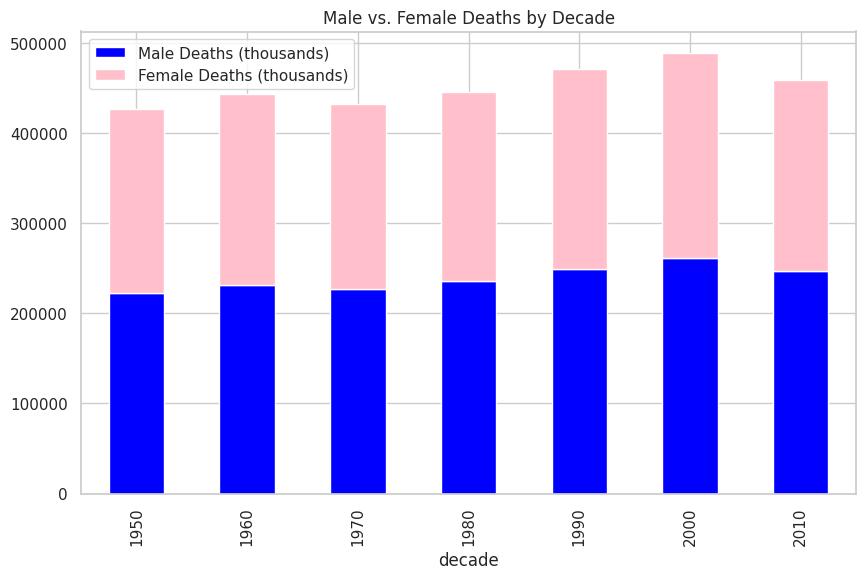

In [0]:
pandas_df['decade'] = (pandas_df['Year_gdp'] // 10) * 10
decade_sums = pandas_df.groupby('decade')[['Male Deaths (thousands)', 'Female Deaths (thousands)']].sum()

decade_sums.plot(kind='bar', stacked=True, color=['blue', 'pink'], figsize=(10, 6))
plt.title('Male vs. Female Deaths by Decade')
plt

#### Trend Over Time: 
The chart shows a trend where the total number of deaths, for both males and females, generally appears to be increasing by decade.

#### Gender Comparison: 
In each decade, the number of female deaths is higher than the number of male deaths. This could be due to various factors, such as a higher life expectancy of females leading to a larger elderly female population that is more susceptible to natural mortality, or it could reflect demographic structures with more females in the population.

### 11. CO-relation between Population and GDP

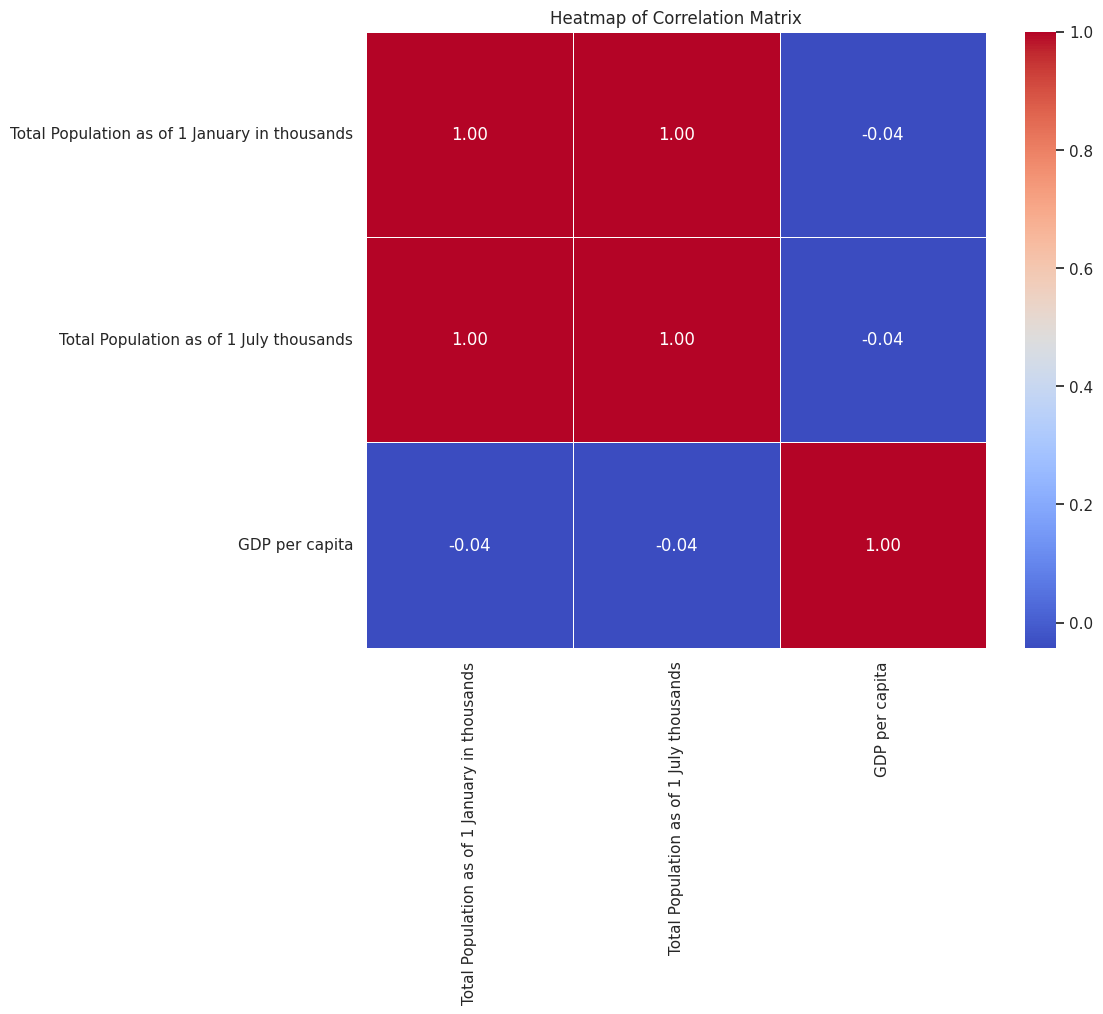

In [0]:
columns = ['Total Population as of 1 January in thousands', 'Total Population as of 1 July thousands', 'GDP per capita']
temp = df[columns].toPandas()
corr_matrix = temp.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

# Predictive Modeling

+-----------------+--------------+
|       prediction|GDP per capita|
+-----------------+--------------+
|4851.480748059625|         595.0|
|4636.726068316864|         618.0|
|4421.977093010086|         626.0|
| 4207.24565970627|         641.0|
|3992.504433212478|         665.0|
+-----------------+--------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 9489.51
R-squared on test data = 0.428028


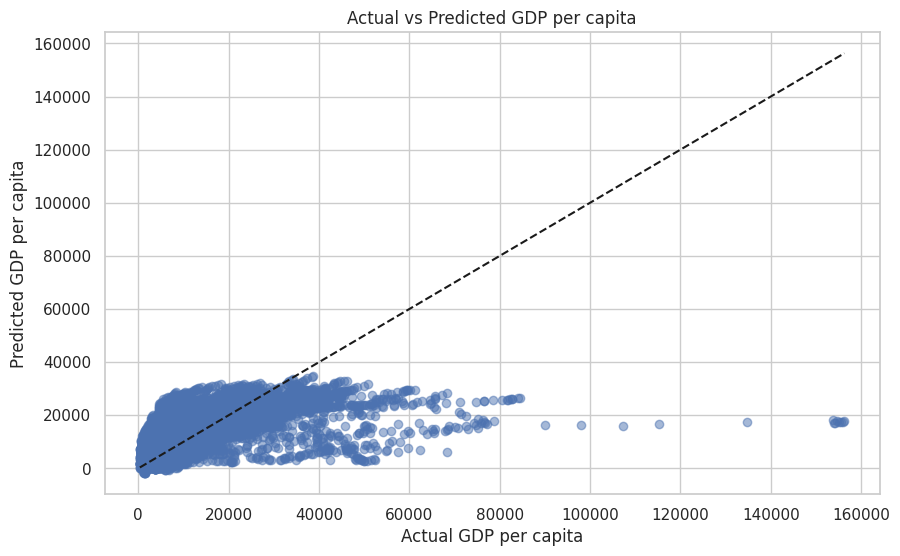

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
# Assembling a vector of features
assembler = VectorAssembler(inputCols=["Total Population as of 1 January in thousands", "Median Age as of 1 July (years)"], outputCol="features")
df_transformed = assembler.transform(df)

# Linear Regression Model
lr = LinearRegression(featuresCol='features', labelCol='GDP per capita')
lr_model = lr.fit(df_transformed)

# Predictions
predictions = lr_model.transform(df_transformed)
predictions.select("prediction", "GDP per capita").show(5)

# Evaluating the model
evaluator = RegressionEvaluator(labelCol="GDP per capita", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(labelCol="GDP per capita", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

# Plotting predictions
pandas_df = predictions.select("prediction", "GDP per capita").toPandas()
plt.figure(figsize=(10,6))
plt.scatter(pandas_df["GDP per capita"], pandas_df["prediction"], alpha=0.5)
plt.xlabel('Actual GDP per capita')
plt.ylabel('Predicted GDP per capita')
plt.title('Actual vs Predicted GDP per capita')
plt.plot([pandas_df["GDP per capita"].min(), pandas_df["GDP per capita"].max()], [pandas_df["GDP per capita"].min(), pandas_df["GDP per capita"].max()], 'k--')
plt.show()


#### Model Performance Metrics:
The root mean squared error (RMSE) is given as 9489.51, which is quite high. This means that, on average, the model's predictions are about $9,489.51 away from the actual GDP per capita values.

#### The R-squared value is 0.428028,
 which indicates that approximately 42.8% of the variance in GDP per capita is explained by the model. This suggests a moderate fit but also indicates that over half of the variability is not captured by the model.

## 

# 3. Cluster Analysis

### Segmentation Using Clustering: Use clustering (e.g., K-means) to find patterns or groups in your data, such as demographic clusters or economic segments.

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

# Assembling data
vec_assembler = VectorAssembler(inputCols=["GDP per capita", "Median Age as of 1 July (years)"], outputCol="features")
df_kmeans = vec_assembler.transform(df)

# K-means Model
kmeans = KMeans(k=5, seed=1)  # 5 clusters
model = kmeans.fit(df_kmeans.select('features'))

# Make predictions
predictions = model.transform(df_kmeans)
predictions.select("features", "prediction").show(5)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[595.0,18.2999992...|         0|
|[618.0,18.1000003...|         0|
|[626.0,17.8999996...|         0|
|[641.0,17.7000007...|         0|
|        [665.0,17.5]|         0|
+--------------------+----------+
only showing top 5 rows

Silhouette with squared euclidean distance = 0.789042466787269
Cluster Centers: 
[3034.78719045   18.64170807]
[1.41237095e+05 2.98999998e+01]
[5.01446255e+04 3.28868074e+01]
[27679.34690252    33.73977368]
[12379.30893434    28.41615826]


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[595.0,18.2999992...|         0|
|[618.0,18.1000003...|         0|
|[626.0,17.8999996...|         0|
|[641.0,17.7000007...|         0|
|        [665.0,17.5]|         0|
+--------------------+----------+
only showing top 5 rows

Silhouette with squared euclidean distance = 0.6924396033627385
Cluster Centers (scaled): 
[-0.54341478 -0.74721583]
[0.60126914 1.45216595]
[10.47390392  0.88634397]
[2.57599121 1.48281517]
[0.02276961 0.34493413]


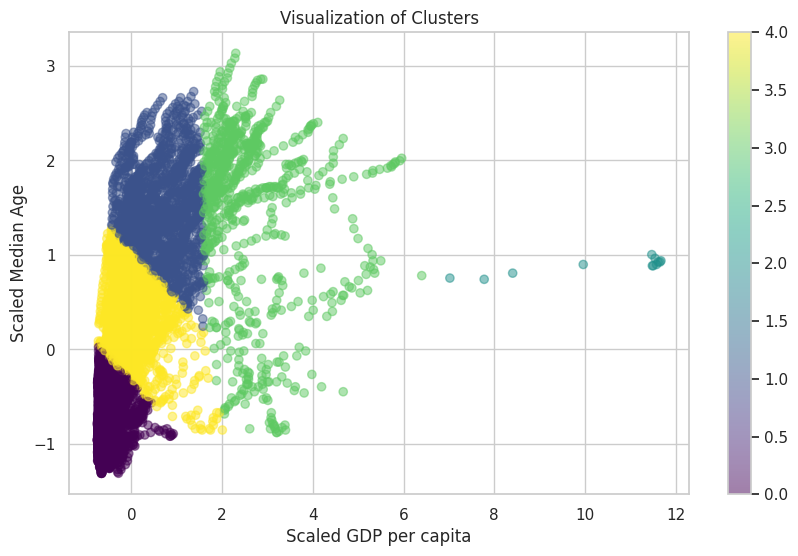

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Assembling data
vec_assembler = VectorAssembler(inputCols=["GDP per capita", "Median Age as of 1 July (years)"], outputCol="features")
df_kmeans = vec_assembler.transform(df)

# Scaling features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
df_scaled = scaler.fit(df_kmeans).transform(df_kmeans)

# K-means Model
kmeans = KMeans(featuresCol="scaledFeatures", k=5, seed=1)  # Consider testing different k values
model = kmeans.fit(df_scaled)

# Make predictions
predictions = model.transform(df_scaled)
predictions.select("features", "prediction").show(5)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Cluster Centers
centers = model.clusterCenters()
print("Cluster Centers (scaled): ")
for center in centers:
    print(center)

# Optionally: Visualizing the clusters
features_np = np.array(predictions.select("scaledFeatures").rdd.map(lambda row: row[0]).collect())
predictions_np = np.array(predictions.select("prediction").rdd.map(lambda row: row[0]).collect())

plt.figure(figsize=(10, 6))
plt.scatter(features_np[:, 0], features_np[:, 1], c=predictions_np, cmap='viridis', alpha=0.5)
plt.xlabel('Scaled GDP per capita')
plt.ylabel('Scaled Median Age')
plt.title('Visualization of Clusters')
plt.colorbar()
plt.show()


#### Data Preparation:
 The features 'GDP per capita' and 'Median Age' are assembled into a feature vector and then scaled. Scaling helps to normalize the data which is important for clustering algorithms like k-means that are sensitive to the scale of the data.

#### Model Evaluation: 
The Silhouette score is a metric used to evaluate the quality of the clustering. A score close to +1 indicates that the clusters are well apart from each other and clearly distinguished. The reported silhouette score is 0.692, suggesting a reasonably good structure of the clusters found by the algorithm. 

#### Interpretation of the Plot:
#### Cluster Separation:
 The plot shows distinct clusters which suggest that the model was able to identify patterns in the data where certain countries or regions group together based on their GDP and median age characteristics.
#### Outliers: 
The isolated points far from the cluster centers could be outliers or special cases.
#### Cluster Density: 
Some clusters appear denser, indicating that data points in these clusters are more closely packed together.

# Randon Forest with Hyper parametre tunning 

### 1. Data Preparation

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Assemble vectors (example features, add or remove as necessary)
feature_columns = ['Total Population as of 1 January in thousands', 'Median Age as of 1 July (years)', 'Population Density as of 1 July (persons per square km)', 'Male Life Expectancy at Birth (years)', 'Female Life Expectancy at Birth (years)']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Optional: Indexing categorical features if any using StringIndexer or OneHotEncoder if necessary


### 2. Model Setup
Set up the Random Forest model.

In [0]:
# Initialize and configure the RandomForestRegressor model
rf = RandomForestRegressor(featuresCol='features', labelCol='GDP per capita')


### 3. Pipeline Setup

In [0]:
# Create a Pipeline
pipeline = Pipeline(stages=[assembler, rf])


### 4. Hyperparameter Tuning

Hyperparameter tuning is the process of finding the set of optimal hyperparameters for a learning algorithm. A hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data.

In [0]:
# Define a parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()


### 5. Cross-Validation Setup
Set up the cross-validator for robust model evaluation.

In [0]:
# Define a CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='GDP per capita'),
                          numFolds=5)  # Use 3+ folds in practice


### 6. Fit Model
Fit the model using the training data.

In [0]:
# Assuming 'df' is your Spark DataFrame containing the necessary columns
# Fit the model
cvModel = crossval.fit(df)

# Fetch best model
bestModel = cvModel.bestModel

### 7.Evaluate and Use the Best Model

In [0]:
avg_metrics = cvModel.avgMetrics

# Printing average metrics with corresponding parameter grid settings
for params, metric in zip(paramGrid, avg_metrics):
    print(params, 'has Metric:', metric)
    print("------------------------------------------------------------------")

{Param(parent='RandomForestRegressor_e97277bc83cd', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestRegressor_e97277bc83cd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestRegressor_e97277bc83cd', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32} has Metric: 6519.961307315597
------------------------------------------------------------------
{Param(parent='RandomForestRegressor_e97277bc83cd', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestRegressor_e97277bc83cd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestRegress

### 8.Retrieve the Best Model

In [0]:
bestRFModel = bestModel.stages[-1]  # Assuming RandomForestRegressor is the last stage in the pipeline

# Now you can access the parameters used by the best RandomForestModel:
print("Best model's number of trees: ", bestRFModel.getNumTrees)
print("Best model's maximum depth: ", bestRFModel.getMaxDepth())
print("Best model's max bins: ", bestRFModel.getMaxBins())

Best model's number of trees:  50
Best model's maximum depth:  15
Best model's max bins:  32


In [0]:
print(bestModel)

PipelineModel_c87d35a3b858


### 9.  Evaluate the Model and Make Predictions on Test Data

In [0]:
# You can split the data into training and testing sets for this purpose
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Make predictions
predictions = bestModel.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="GDP per capita", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 1290.4


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create evaluators for RMSE, MAE, and R-squared
evaluatorRMSE = RegressionEvaluator(labelCol="GDP per capita", predictionCol="prediction", metricName="rmse")
evaluatorMAE = RegressionEvaluator(labelCol="GDP per capita", predictionCol="prediction", metricName="mae")
evaluatorR2 = RegressionEvaluator(labelCol="GDP per capita", predictionCol="prediction", metricName="r2")

# Compute metrics
rmse = evaluatorRMSE.evaluate(predictions)
mae = evaluatorMAE.evaluate(predictions)
r2 = evaluatorR2.evaluate(predictions)

# Print out the metrics
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("R-squared on test data = %g" % r2)


Root Mean Squared Error (RMSE) on test data = 1290.4
Mean Absolute Error (MAE) on test data = 681.986
R-squared on test data = 0.988973


### 1. Root Mean Squared Error (RMSE): 1290.4
#### A lower RMSE is better as it indicates that the errors between predicted values and actual values are smaller. An RMSE of 1290.4 means that the standard deviation of the prediction errors is about 1290.4 units of GDP per capita
RMSE is the standard deviation of the residuals (prediction errors). 
Residuals are a measure of how far from the regression line data points are, and RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

### 2. Mean Absolute Error (MAE): 681.986
####  MAE of 681.986 indicates that, on average, the model predictions are within approximately 682 units of the actual values


# 3. R-squared (R²): 0.988973
## R-squared of 0.988973 suggests that about 98.9% of the variation in the GDP per capita is explained by the variables included in the model
### R-squared is a statistical measure of how close the data are to the fitted regression line. 

# ----------------

# Visualizing the model predictions against the actual values

In [0]:
# Assuming 'predictions' is the DataFrame that includes both the predictions and the actual 'GDP per capita' values
# Let's add a residual column to it for plotting purposes
predictions = predictions.withColumn('Residuals', predictions['GDP per capita'] - predictions['prediction'])
predictions_df = predictions.toPandas()  # Converting to Pandas DataFrame for plotting


# Scatter Plot of Actual vs. Predicted Values
This plot will help visualize how closely the predicted values match the actual values.

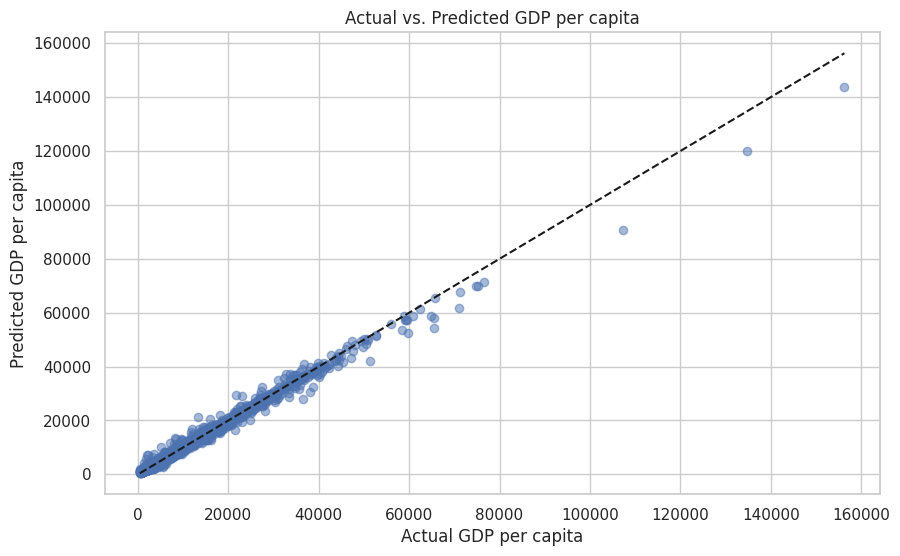

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['GDP per capita'], predictions_df['prediction'], alpha=0.5)
plt.plot([predictions_df['GDP per capita'].min(), predictions_df['GDP per capita'].max()], [predictions_df['GDP per capita'].min(), predictions_df['GDP per capita'].max()], '--k')  # Line for perfect predictions
plt.xlabel('Actual GDP per capita')
plt.ylabel('Predicted GDP per capita')
plt.title('Actual vs. Predicted GDP per capita')
plt.show()


# Residual Plot
A residual plot shows the differences (or errors) between predicted and actual values. If the residuals are randomly dispersed around the horizontal axis, the model is appropriate for the data

Residual Plot: The residual plot helps in identifying patterns in the prediction errors. Ideally, the residuals should be scattered randomly around zero, indicating that the model's predictions are unbiased at all levels of the response variable.

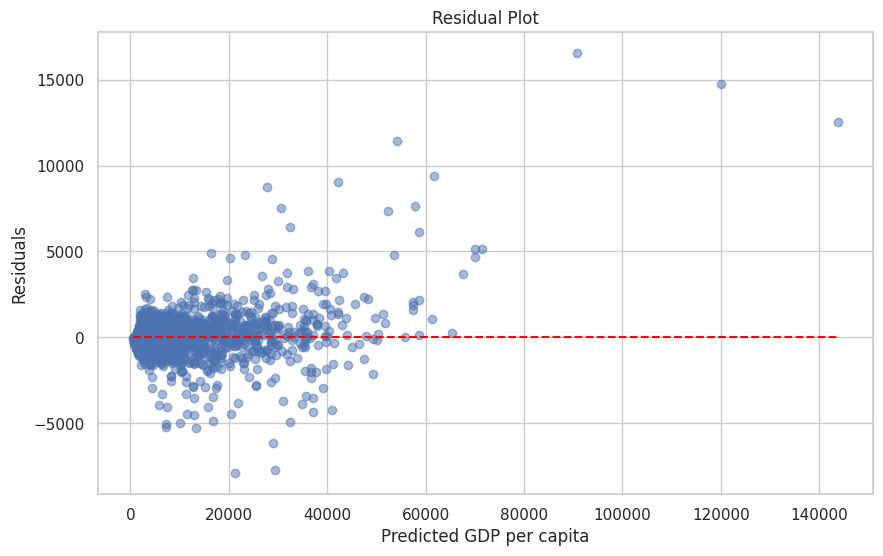

In [0]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['prediction'], predictions_df['Residuals'], alpha=0.5)
plt.hlines(y=0, xmin=predictions_df['prediction'].min(), xmax=predictions_df['prediction'].max(), colors='red', linestyles='--')
plt.xlabel('Predicted GDP per capita')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
